# Train a neural network for mri generation using progressive growing

In this notebook, we will use Nobrainer to train a model for brain MRI generation. Brain MRI generation is a useful task in synthetically creating neuroimaging data. We will use a Generative Adversarial Network to model the generation and use a progressive growing training method for high quality generation at higher resolutions.

In the following cells, we will:

1. Get sample T1-weighted MR scans as features.
2. Convert the data to TFRecords format.
3. Instantiate a progressive convolutional neural network for generator and discriminator.
4. Create a Dataset of the features.
5. Instantiate a trainer and choose a loss function to use.
6. Train on part of the data in two phases (transition and resolution).
7. Repeat steps 4-6 for each growing resolution.
8. Generate some images using trained model

## Google Colaboratory

If you are using Colab, please switch your runtime to GPU. To do this, select `Runtime > Change runtime type` in the top menu. Then select GPU under `Hardware accelerator`. A GPU greatly speeds up training.

In [ ]:
!pip install --no-cache-dir nilearn nobrainer

In [ ]:
import nobrainer

# Get sample features and labels

We use 9 pairs of volumes for training and 1 pair of volumes for evaluation. Many more volumes would be required to train a model for any useful purpose.

In [ ]:
csv_of_filepaths = nobrainer.utils.get_data()
filepaths = nobrainer.io.read_csv(csv_of_filepaths)

train_paths = filepaths[:9]

# Convert medical images to TFRecords

Remember how many full volumes are in the TFRecords files. This will be necessary to know how many steps are in on training epoch. The default training method needs to know this number, because Datasets don't always know how many items they contain.

In [ ]:
!mkdir -p data

In [ ]:
resolution_batch_size_map = {8: 1, 16: 1, 32: 1, 64: 1, 128: 1, 256: 1} 
# resolution_batch_size_map = {8: 32, 16: 16, 32: 8, 64: 4, 128: 1, 256: 1} uncomment when sufficient compute is available
resolutions = sorted(list(resolution_batch_size_map.keys()))

nobrainer.tfrecord.write(
    features_labels=train_paths,
    filename_template='data/data-train_shard-{shard:03d}.tfrec',
    examples_per_shard=3, # change for larger dataset
    multi_resolution=True,
    resolutions=resolutions)

# Set the Hyperparameters

In [ ]:
latent_size = 256
g_fmap_base = 1024
d_fmap_base = 1024
# latent_size = 1024 uncomment when sufficient compute is available
# g_fmap_base = 4096 uncomment when sufficient compute is available
# d_fmap_base = 4096 uncomment when sufficient compute is available
num_parallel_calls = 4
iterations = int(10)
# iterations = int(300e3) uncomment when sufficient compute is available
lr = 1e-4

# Create logging directories

In [ ]:
from pathlib import Path

save_dir = 'pgan'

save_dir = Path(save_dir)
generated_dir = save_dir.joinpath('generated')
model_dir = save_dir.joinpath('saved_models')
log_dir = save_dir.joinpath('logs')

save_dir.mkdir(exist_ok=True)
generated_dir.mkdir(exist_ok=True)
model_dir.mkdir(exist_ok=True)

# Instantiate a neural network

In [ ]:
generator, discriminator = nobrainer.models.progressivegan(latent_size, 
                                                           g_fmap_base=g_fmap_base, 
                                                           d_fmap_base=d_fmap_base)

# Train the network progressively for each resolution

In [ ]:
import tensorflow as tf

In [ ]:
for resolution in resolutions:
    
    # create a train dataset with features for resolution
    dataset_train = nobrainer.dataset.get_dataset(
        file_pattern="data/*res-%03d*.tfrec"%(resolution),
        batch_size=resolution_batch_size_map[resolution],
        num_parallel_calls=num_parallel_calls,
        volume_shape=(resolution, resolution, resolution),
        n_classes=1, # dummy labels as this is unsupervised training
        scalar_label=True,
        normalizer=None
    )

    # grow the networks by one (2^x) resolution
    generator.add_resolution()
    discriminator.add_resolution()

    # instantiate a progressive training helper
    progressive_gan_trainer = nobrainer.training.ProgressiveGANTrainer(
        generator=generator,
        discriminator=discriminator,
        gradient_penalty=True)

    # compile with optimizers and loss function of choice
    progressive_gan_trainer.compile(
        g_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.0, beta_2=0.99, epsilon=1e-8),
        d_optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.0, beta_2=0.99, epsilon=1e-8),
        g_loss_fn=nobrainer.losses.wasserstein,
        d_loss_fn=nobrainer.losses.wasserstein
        )

    steps_per_epoch = iterations//resolution_batch_size_map[resolution]
    # save_best_only is set to False as it is an adversarial loss
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(str(model_dir), save_weights_only=True, save_best_only=False, save_freq=10)

    # Train at resolution
    print('Resolution : {}'.format(resolution))

    print('Transition phase')
    progressive_gan_trainer.fit(
        dataset_train,
        phase='transition',
        resolution=resolution,
        steps_per_epoch=steps_per_epoch, # necessary for repeat dataset
        callbacks=[model_checkpoint_callback])

    print('Resolution phase')
    progressive_gan_trainer.fit(
        dataset_train,
        phase='resolution',
        resolution=resolution,
        steps_per_epoch=steps_per_epoch,
        callbacks=[model_checkpoint_callback])

    # save the final weights
    generator.save(str(model_dir.joinpath('generator_res_{}'.format(resolution))))

In [ ]:
generator.summary()

In [ ]:
discriminator.summary()

The following code demonstrates how a model trained as shown above could be used to generate fake images.

```python
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib

latents = tf.random.normal((1, latent_size))
model_paths = model_dir.glob("generator_res*")
for model_path in model_paths:
    generator = tf.saved_model.load(str(model_path))
    generate = generator.signatures["serving_default"]
    img = generate(latents)["generated"]
    img = np.squeeze(img)
    img = nib.Nifti1Image(img.astype(np.uint8), np.eye(4))
    fig = plt.figure(figsize=(12, 6))
    plotting.plot_anat(anat_img=img, figure=fig, title=model_path.name.split("_")[-1])
```

Instead we will retrieve a pre-trained model to generate some brains.

In [ ]:
!wget -O- http://neuro.debian.net/lists/bionic.us-nh.full | tee /etc/apt/sources.list.d/neurodebian.sources.list \
 && export GNUPGHOME="$(mktemp -d)" \
 && echo "disable-ipv6" >> ${GNUPGHOME}/dirmngr.conf \
 && apt-key adv --homedir $GNUPGHOME --recv-keys --keyserver hkp://pool.sks-keyservers.net:80 0xA5D32F012649A5A9 \
 && apt-get update \
 && apt-get install git-annex-standalone git

In [ ]:
!pip install --no-cache-dir nilearn datalad datalad-osf

In [ ]:
!datalad clone https://github.com/neuronets/trained-models && \
  cd trained-models && git-annex enableremote osf-storage && \
  datalad get -r -s osf-storage neuronets/braingen/0.1.0/

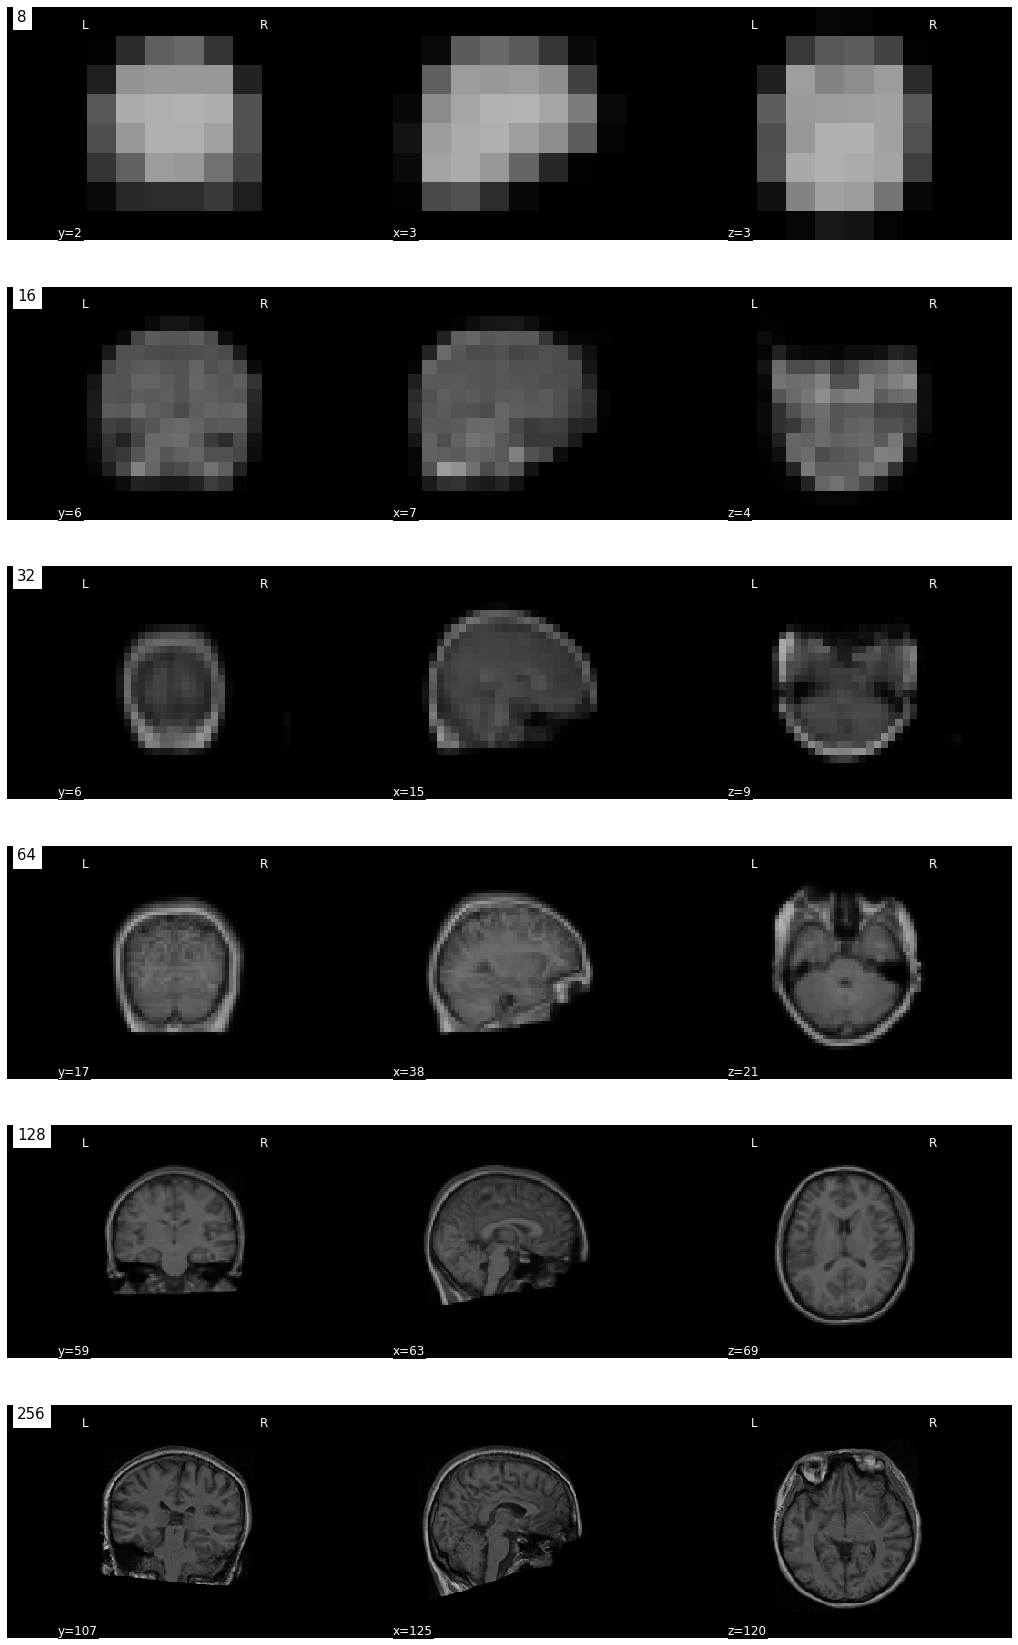

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib
 
model_dir = Path("trained-models/neuronets/braingen/0.1.0")
latents = tf.random.normal((1, 1024))
model_paths = model_dir.glob("generator_res*")
fig, ax = plt.subplots(6, 1, figsize=(18, 30))
index = 0

"""
Since each generator continues training, the same latent will give rise to 
different fake brains for each generator.
"""
for model_path in sorted(model_paths, key=lambda x: int(x.name.split("_")[-1])):
    generator = tf.saved_model.load(str(model_path))
    generate = generator.signatures["serving_default"]
    img = generate(latents)["generated"]
    img = np.squeeze(img)
    img = nib.Nifti1Image(img.astype(np.uint8), np.eye(4))
    plotting.plot_anat(anat_img=img, figure=fig, axes=ax[index], 
                       draw_cross=False,
                       title=model_path.name.split("_")[-1])
    index += 1